### Importar librerías

In [26]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Lectura de datos

In [27]:
train = pd.read_csv("train.csv", sep = ",") # Definimos na_values para identificar bien los valores perdidos
test = pd.read_csv("test.csv", sep = ",") # Definimos na_values para identificar bien los valores perdidos

# Dividir en características (X) y objetivo (y)
X_train = train.drop(columns=['price', 'id'])
Y_train = train['price']

# Mantener la columna 'id' para el test
test_ids = test['id']
X_test = test.copy()
X_test = X_test.drop(columns=['id'])

# Imprimir información general sobre los datos
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
dtypes: int64(2), object(9)
memory usage: 15.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null

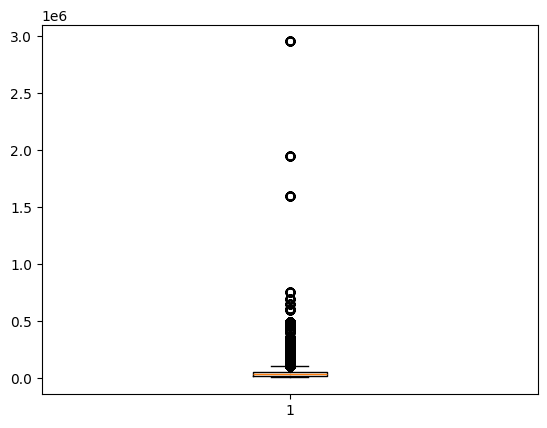

In [28]:
plt.boxplot(train['price'])
plt.show()

### Preprocesamiento

In [29]:
#Identificamos valores vacios
print(X_train.isnull().sum())
print(X_test.isnull().sum())

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
dtype: int64
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [30]:
# Transformar la variable de precio a una escala logarítmica
Y_train = np.log(train['price'] + 1)
Y_train.describe()

count    188533.000000
mean         10.291787
std           0.844173
min           7.601402
25%           9.741027
50%          10.336114
75%          10.817796
max          14.898699
Name: price, dtype: float64

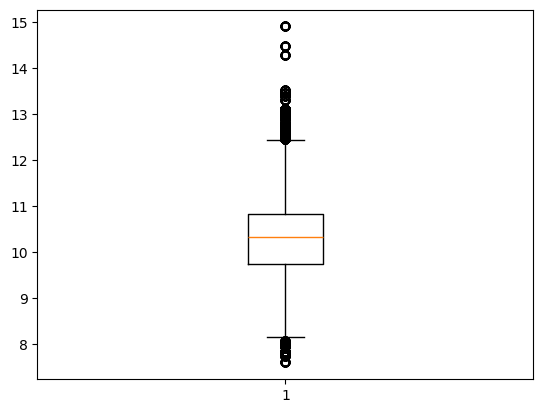

In [31]:
plt.boxplot(Y_train)
plt.show()

In [32]:
# Identificar columnas categóricas
categorical_columns = list(X_train.select_dtypes(exclude=np.number).columns)
numerical_columns = list(X_train.select_dtypes(include=np.number).columns)

for col in numerical_columns:
    if X_train[col].isnull().sum() > 0:
        X_train.fillna({col: X_train[col].median()}, inplace=True)
    if X_test[col].isnull().sum() > 0:
        X_test.fillna({col: X_test[col].median()}, inplace=True)

for col in categorical_columns:
    if X_train[col].isnull().sum() > 0:
        X_train.fillna({col: 'unknown'}, inplace=True)
    if X_test[col].isnull().sum() > 0:
        X_test.fillna({col: 'unknown'}, inplace=True)

for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

for col in numerical_columns:
    X_train[col] = X_train[col].astype('int64')
    X_test[col] = X_test[col].astype('int64')

Y_train = Y_train.astype('float64')

print(X_train.isnull().sum())
print(X_test.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


In [33]:
X_train.info()
Y_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   brand         188533 non-null  category
 1   model         188533 non-null  category
 2   model_year    188533 non-null  int64   
 3   milage        188533 non-null  int64   
 4   fuel_type     188533 non-null  category
 5   engine        188533 non-null  category
 6   transmission  188533 non-null  category
 7   ext_col       188533 non-null  category
 8   int_col       188533 non-null  category
 9   accident      188533 non-null  category
 10  clean_title   188533 non-null  category
dtypes: category(9), int64(2)
memory usage: 5.4 MB
<class 'pandas.core.series.Series'>
RangeIndex: 188533 entries, 0 to 188532
Series name: price
Non-Null Count   Dtype  
--------------   -----  
188533 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
Range

In [34]:
categorical_columns, numerical_columns

(['brand',
  'model',
  'fuel_type',
  'engine',
  'transmission',
  'ext_col',
  'int_col',
  'accident',
  'clean_title'],
 ['model_year', 'milage'])

### División en entrenamiento y validacion

In [35]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [36]:
X_train.info()
X_val.info()
Y_train.info()
Y_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150826 entries, 184031 to 121958
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   brand         150826 non-null  category
 1   model         150826 non-null  category
 2   model_year    150826 non-null  int64   
 3   milage        150826 non-null  int64   
 4   fuel_type     150826 non-null  category
 5   engine        150826 non-null  category
 6   transmission  150826 non-null  category
 7   ext_col       150826 non-null  category
 8   int_col       150826 non-null  category
 9   accident      150826 non-null  category
 10  clean_title   150826 non-null  category
dtypes: category(9), int64(2)
memory usage: 5.5 MB
<class 'pandas.core.frame.DataFrame'>
Index: 37707 entries, 111355 to 105952
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   brand         37707 non-null  category
 1   model 

### CatBoost

In [42]:
# CatBoost
cat_model = cat_model = CatBoostRegressor(
    iterations=500,                # Menos iteraciones para evitar sobreajuste
    learning_rate=0.1,            # Tasa de aprendizaje más baja
    depth=6,                       # Menor profundidad para simplificar el modelo
    random_seed=42,                # Semilla para reproducibilidad
    verbose=1,                     # Salida detallada durante el entrenamiento
)
cat_model.fit(X_train, Y_train, cat_features=categorical_columns, eval_set=(X_val, Y_val))

0:	learn: 0.7971272	test: 0.7997906	best: 0.7997906 (0)	total: 101ms	remaining: 50.2s
1:	learn: 0.7566662	test: 0.7595852	best: 0.7595852 (1)	total: 186ms	remaining: 46.2s
2:	learn: 0.7216261	test: 0.7246373	best: 0.7246373 (2)	total: 259ms	remaining: 42.9s
3:	learn: 0.6920369	test: 0.6951923	best: 0.6951923 (3)	total: 336ms	remaining: 41.6s
4:	learn: 0.6669724	test: 0.6701814	best: 0.6701814 (4)	total: 417ms	remaining: 41.3s
5:	learn: 0.6452030	test: 0.6485771	best: 0.6485771 (5)	total: 504ms	remaining: 41.5s
6:	learn: 0.6269621	test: 0.6303677	best: 0.6303677 (6)	total: 574ms	remaining: 40.4s
7:	learn: 0.6115422	test: 0.6149339	best: 0.6149339 (7)	total: 651ms	remaining: 40s
8:	learn: 0.5984319	test: 0.6020056	best: 0.6020056 (8)	total: 726ms	remaining: 39.6s
9:	learn: 0.5851691	test: 0.5885683	best: 0.5885683 (9)	total: 801ms	remaining: 39.2s
10:	learn: 0.5736992	test: 0.5768951	best: 0.5768951 (10)	total: 868ms	remaining: 38.6s
11:	learn: 0.5642628	test: 0.5672417	best: 0.5672417 (

In [43]:
cat_predictions_test = np.expm1(cat_model.predict(X_test))
cat_predictions_train = np.expm1(cat_model.predict(X_train))
rmse_train = np.sqrt(mean_squared_error(Y_train, cat_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': cat_predictions_test
    })
submission.to_csv('submission_cat2_logprice.csv', index=False)

RMSE Train: 43804.19460266448


### LightGBM

In [45]:
# LightGBM
lgb_model = LGBMRegressor(
boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=500,
    objective='regression',
    force_row_wise=True,
    max_bin=10000,
    n_jobs=-1,
    verbose=1
)
lgb_model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_val, Y_val)], 
    eval_metric='rmse',
    categorical_feature=categorical_columns,
)

[LightGBM] [Info] Total Bins 7257
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 10.291542


c:\Users\aleja\anaconda3\envs\IN\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(force_row_wise=True, max_bin=10000, n_estimators=500, n_jobs=-1,
              objective='regression', verbose=1)

In [24]:
lgb_predictions_test = np.expm1(lgb_model.predict(X_test))
lgb_predictions_train = np.expm1(lgb_model.predict(X_train))
rmse_train = np.sqrt(mean_squared_error(Y_train, lgb_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': lgb_predictions_test
    })
submission.to_csv('submission_lgb3_logprice.csv', index=False)

RMSE Train: 52991.352934935174


### RandomForestRegressor

In [46]:
X_test_encoded = X_test.copy()
for col in categorical_columns:
    X_test_encoded[col] = LabelEncoder().fit_transform(X_test_encoded[col])

In [47]:
# Crear un diccionario para almacenar los LabelEncoders para cada columna categórica
label_encoders = {}

# Copiar X_train y X_val para no modificar los originales
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

# Aplicar LabelEncoder a cada columna categórica
for col in categorical_columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])

    # Imputar valores no vistos en el conjunto de validación con 'unknown'
    X_val_encoded[col] = X_val_encoded[col].map(lambda s: 'unknown' if s not in le.classes_ else s)
    # Añadir 'unknown' a las clases del LabelEncoder
    le.classes_ = np.append(le.classes_, 'unknown')

    X_val_encoded[col] = le.transform(X_val_encoded[col])
    label_encoders[col] = le

# Crear y entrenar el modelo RandomForestRegressor
rf_model = RandomForestRegressor(
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    n_jobs=-1, 
    n_estimators=500, 
    random_state=42,
    verbose=1
)
rf_model.fit(X_train_encoded, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.6s finished


RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

### Red Neuronal

In [48]:
# Escalar variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Red Neuronal
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train_scaled, Y_train, epochs=50, batch_size=20, validation_data=(X_val_scaled, Y_val), verbose=1)

Epoch 1/50


c:\Users\aleja\anaconda3\envs\IN\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.7651 - val_loss: 6.5910
Epoch 2/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2852 - val_loss: 6.2158
Epoch 3/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2818 - val_loss: 5.6503
Epoch 4/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2775 - val_loss: 5.1063
Epoch 5/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2764 - val_loss: 4.6218
Epoch 6/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.2716 - val_loss: 4.5029
Epoch 7/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2693 - val_loss: 3.9446
Epoch 8/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2688 - val_loss: 3.6190
Epoch 9/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2654 - val_loss: 4.0834
Epoch 10/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.2670 - val_loss: 3.5154
Epoch 11/50
7542/7542 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.2677 - val_loss: 3.2671
Epoch 12/50
7542/7542 ━━━━━━━━━━━━━━━━━━

In [49]:
dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=Y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, enable_categorical=True)

params = {
    'objective': 'reg:squarederror',    # Tarea de regresión
    'device': 'cuda',                   # Uso de GPU
    'max_depth': 6,                
    'eta': 0.1,                  
    'subsample': 0.8,               
    'colsample_bytree': 0.8,        
}

num_boost_round = 100           
early_stopping_rounds = 100          

evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=num_boost_round, 
    evals=evals, 
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)

[0]	train-rmse:0.80861	eval-rmse:0.81196
[1]	train-rmse:0.76358	eval-rmse:0.76873
[2]	train-rmse:0.74029	eval-rmse:0.74665
[3]	train-rmse:0.70120	eval-rmse:0.70934
[4]	train-rmse:0.66720	eval-rmse:0.67676
[5]	train-rmse:0.63802	eval-rmse:0.64972
[6]	train-rmse:0.61427	eval-rmse:0.62753
[7]	train-rmse:0.59404	eval-rmse:0.60943
[8]	train-rmse:0.57583	eval-rmse:0.59291
[9]	train-rmse:0.56593	eval-rmse:0.58430
[10]	train-rmse:0.55174	eval-rmse:0.57132
[11]	train-rmse:0.53853	eval-rmse:0.56000
[12]	train-rmse:0.52705	eval-rmse:0.55009
[13]	train-rmse:0.51818	eval-rmse:0.54290
[14]	train-rmse:0.50972	eval-rmse:0.53622
[15]	train-rmse:0.50313	eval-rmse:0.53096
[16]	train-rmse:0.49692	eval-rmse:0.52648
[17]	train-rmse:0.49183	eval-rmse:0.52244
[18]	train-rmse:0.48758	eval-rmse:0.51914
[19]	train-rmse:0.48358	eval-rmse:0.51621
[20]	train-rmse:0.48002	eval-rmse:0.51381
[21]	train-rmse:0.47682	eval-rmse:0.51197
[22]	train-rmse:0.47407	eval-rmse:0.51020
[23]	train-rmse:0.47166	eval-rmse:0.50875
[2

In [50]:
xgb_predictions_test = np.expm1(model.predict(dtest))
xgb_predictions_train = np.expm1(model.predict(dtrain))

rmse_train = np.sqrt(mean_squared_error(Y_train, xgb_predictions_train))
print(f"RMSE Train: {rmse_train}")
submission = pd.DataFrame({
    'id': test_ids, 
    'price': xgb_predictions_test
    })
submission.to_csv('submission_xgb_logprice.csv', index=False)

RMSE Train: 45741.79738443431


### Evaluar modelos
Predicciones del test

In [51]:
# Hacer predicciones en el conjunto de prueba
cat_predictions_test = np.expm1(cat_model.predict(X_test))
lgb_predictions_test = np.expm1(lgb_model.predict(X_test))
rf_predictions_test = np.expm1(rf_model.predict(X_test_encoded))
nn_predictions_test = np.expm1(nn_model.predict(X_test_scaled).flatten())

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.0s


   1/3928 ━━━━━━━━━━━━━━━━━━━━ 2:24 37ms/step

[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.2s
[Parallel(n_jobs=28)]: Done 500 out of 500 | elapsed:    0.3s finished


3928/3928 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step


Predicciones del entrenamiento

In [52]:
cat_predictions_train = np.expm1(cat_model.predict(X_train))
lgb_predictions_train = np.expm1(lgb_model.predict(X_train))
rf_predictions_train = np.expm1(rf_model.predict(X_train_encoded))
nn_predictions_train = np.expm1(nn_model.predict(X_train_scaled).flatten())

[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.1s


   1/4714 ━━━━━━━━━━━━━━━━━━━━ 1:59 25ms/step

[Parallel(n_jobs=28)]: Done 394 tasks      | elapsed:    0.3s
[Parallel(n_jobs=28)]: Done 500 out of 500 | elapsed:    0.4s finished


4714/4714 ━━━━━━━━━━━━━━━━━━━━ 3s 583us/step


### Ensamblar modelos

In [54]:
# Definir los pesos para cada modelo
weights = {
    'catboost': 0.2,
    'lightgbm': 0.2,
    'randomforest': 0.2,
    'xgboost': 0.2,
    'nn': 0.2
}

final_predictions_test = (
    weights['catboost'] * cat_predictions_test +
    weights['lightgbm'] * lgb_predictions_test +
    weights['randomforest'] * rf_predictions_test +
    weights['xgboost'] * xgb_predictions_test +
    weights['nn'] * nn_predictions_test
)

# Crear un DataFrame con las predicciones finales
submission = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions_test
})

# Guardar las predicciones en un archivo CSV
submission.to_csv('submission_all_xgboost_logprice.csv', index=False)

final_predictions_train = (
    weights['catboost'] * cat_predictions_train +
    weights['lightgbm'] * lgb_predictions_train +
    weights['randomforest'] * rf_predictions_train +
    weights['xgboost'] * xgb_predictions_train +
    weights['nn'] * nn_predictions_train
)

# Calcular el error cuadrático medio en el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(Y_train, final_predictions_train))
print(f'RMSE en el conjunto de entrenamiento: {rmse_train}')

RMSE en el conjunto de entrenamiento: 44242.867869424204
